# HOMEWORK 3 NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---
Student: Matteo Grandin
---
id: 2020374

# Reinforced Learning

### General overview
In this homework you will learn how to implement and test neural network models for
solving reinforcement learning problems. The basic tasks for the homework will require to implement some
extensions to the code that you have seen in the Lab. The advanced tasks will require to train and test your
learning agent on a different type of input (image pixels) or Gym environment. You can just choose one of
the advanced tasks to get the maximum grade. If you are interested in improving your skills, feel free to try
both advanced tasks. Given the higher computational complexity of RL, in this homework you don’t need to
tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged
to play with model hyperparameters to find a satisfactory configuration.


- 3 pt: use the notebook of Lab 07 to study how the exploration profile (either using eps-greedy or
softmax) impacts the learning curve. Tune a bit the model hyperparameters or tweak the reward
function to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).

YOU CAN DO JUST 1 OR BOTH
- 5 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using
directly the screen pixels, rather than the compact state representation used during the Lab (cart
position, cart velocity, pole angle, pole angular velocity). NB: this will require to change the
“observation_space” and to look for smart ways of encoding the pixels in a compact way to reduce
computational complexity (e.g., crop the image around the pole, use difference of consecutive frames
as input to consider temporal context, etc.).

OR

- 5 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym
environment you like from the available list, or even explore other simulation platforms.

In [1]:
# Boolean value to check if we are in colab or not
colab = False 
show_video = False
show_render = False
load_model = True

In [2]:
if colab:
    !pip install gym
else:
    %pip install gym

Note: you may need to restart the kernel to use updated packages.


In [3]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
if colab:
    !apt update
    !apt-get install python-opengl -y
    !apt install xvfb -y
    !pip install pyvirtualdisplay
    !pip install piglet
    import glob
    import io
    import base64
    import os
    from IPython.display import HTML
    from IPython import display as ipythondisplay
    from pyvirtualdisplay import Display
    from gym.wrappers import Monitor

    display = Display(visible=0, size=(1400, 900))
    display.start()

    if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
        !bash ../xvfb start
        %env DISPLAY=:1

    """
    Utility functions to enable video recording of gym environment and displaying it
    To enable video, just do "env = wrap_env(env)""
    """

    def show_videos():
        mp4list = glob.glob('video/*.mp4')
        mp4list.sort()
        for mp4 in mp4list:
            print(f"\nSHOWING VIDEO {mp4}")
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                        loop controls style="height: 400px;">
                        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                    </video>'''.format(encoded.decode('ascii'))))
            
    def wrap_env(env, video_callable=None):
        env = Monitor(env, './video', force=True, video_callable=video_callable)
        return env

In [5]:
class ReplayMemory(object):

    def __init__(self, capacity, state_size=2):
        #capacity, state, action, reward, next_state, mask
        self.memory = torch.zeros((capacity, 2*state_size+1+1+1), dtype=torch.float32, device=device) #capacity, action, reward, 2 states
        self.state_size = state_size
        self.memory_index = 0
        self.capacity = capacity
        self.full = False

    def push(self, state, action, next_state, reward):
        if state is None or action is None or reward is None:
            print("WARNING: None value passed to ReplayMemory.push()")
            return
        # TODO: Add the tuple (state, action, next_state, reward) to the queue
        s = torch.from_numpy(state).float().to(device)
        a = torch.tensor([action], dtype=torch.float32, device=device)
        r = torch.tensor([reward], dtype=torch.float32, device=device)
        if next_state is not None:
            next_s = torch.from_numpy(next_state).float().to(device) 
            mask = torch.tensor([1], dtype=torch.float32, device=device)
        else:
            next_s = torch.zeros((self.state_size), dtype=torch.float32, device=device)
            mask = torch.tensor([0], dtype=torch.float32, device=device) # mask is false
        
        to_add = torch.cat((s, a, r, next_s, mask), dim=0 )
        #assert to_add.shape == (1, 2*self.state_size+1+1+1),  f"to_add: {to_add.shape}, \n {to_add}"
        self.memory[self.memory_index, :] = to_add

        #increase the index, and wrap it around if it is bigger than the capacity
        if self.memory_index == self.capacity-1:
            self.full = True
        self.memory_index = (self.memory_index + 1) % self.memory.shape[0]
        
    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        # select indeces
        pool = self.capacity if self.full else self.memory_index-1
        indeces = np.random.choice(pool, batch_size, replace=False)
        # return the samples
        ret = self.memory[indeces, :]
        states = ret[:, 0:self.state_size].unsqueeze(1)
        actions = ret[:, self.state_size].long()
        rewards = ret[:, self.state_size+1].float()
        non_final_mask = ret[:, self.state_size+2].bool()
        non_final_next_states = ret[:, self.state_size+3:].unsqueeze(1)
        non_final_next_states = non_final_next_states[non_final_mask]

        #print(f"states: {states.shape}, actions: {actions.shape}, rewards: {rewards.shape}, non_final_next_states: {non_final_next_states.shape}, non_final_mask: {non_final_mask.shape}")
        return states, actions, rewards, non_final_next_states, non_final_mask


    def __len__(self):
        if self.full:
            return self.capacity
        else:
            return self.memory_index
        # return len(self.memory) # Return the number of samples currently stored in the memory

In [6]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()
        n_hid = 128
        self.linear = nn.Sequential(
            #inpt layer
            nn.Linear(state_space_dim, n_hid),
            nn.Tanh(),
            #nn.Dropout(0.2), #bad
            #hidden layer
            nn.Linear(n_hid, n_hid),
            nn.Tanh(),
            #nn.Dropout(0.2), #bad
            #outpt layer
            nn.Linear(n_hid, action_space_dim),
                )

    def forward(self, x):
        return self.linear(x)

## Exploration Policy

In [7]:
def choose_action_epsilon_greedy(net, state, epsilon):
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32,device=device) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.cpu().numpy()

In [8]:
def choose_action_softmax(net, state, temperature):
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).cpu().numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.cpu().numpy()

### Exploration profile

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

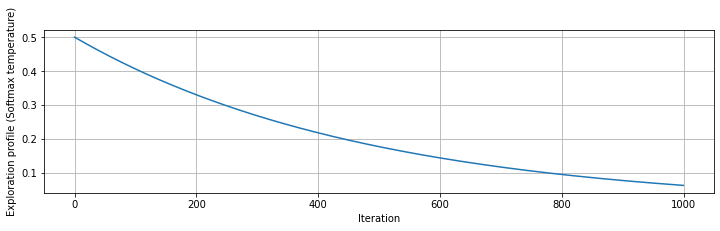

In [9]:
### Define exploration profile
def get_exploration_profile(initial_value=0.5, num_iterations=1000, speed = 3): # speed = speed of convergence, bigger is faster to reach 0
    if initial_value < 0:
        raise Exception('The initial value must be > 0')
    if initial_value > 1:
        exp_decay = np.exp(-np.log(initial_value) / num_iterations * speed) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
    else :
        exp_decay = np.exp(np.log(initial_value) / num_iterations * speed)
    exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]
    return exploration_profile

exploration_profile = get_exploration_profile()

### Plot exploration profile
plt.figure(figsize=(12,3))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

# Gym Environment ('MountainCar-v0')

In [10]:
### Create environment
chosen_env = 'MountainCar-v0'
env = gym.make(chosen_env) # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n
print(f"state_space_dim: {state_space_dim}, action_space_dim: {action_space_dim}")

if colab:
  env = wrap_env(env, video_callable=lambda episode_id: True)

state_space_dim: 2, action_space_dim: 3


# Network update

In [11]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97  #0.97 gamma parameter for the long term reward 
replay_memory_capacity = 20000   #10000 Replay memory capacity 
lr = 2e-2   #1e-2 Optimizer learning rate 
target_net_update_steps = 5   #10 Number of episodes to wait before updating the target network 
batch_size = 4096   #128 Number of samples to take from the replay memory for each update 
bad_state_penalty = 0   #0 Penalty to the reward when we are in a bad state (in this case when the pole falls down)
min_samples_for_training = 5000   #1000 Minimum samples in the replay memory to enable the training 
use_epsilon_greedy = False   #False Use epsilon greedy exploration or not 
#set up exploration profile for softmax
initial_value = 4 #5 Initial temperature/epsilon value for the exploration profile 
num_iterations = 300 # Number of episodes 1000, 
convergence_speed = 6 #6 Speed of convergence of the exploration profile  
exploration_profile = get_exploration_profile(initial_value, num_iterations, speed = convergence_speed)

lowering target_net_update_steps from 10 to 8 had a huge impact, learning rate could be set higher too and gamma could be lowered.

In [12]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim).to(device)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim).to(device)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

#list of losses and scores
losses, scores = [],[]

In [13]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
  # Sample the data from the replay memory
  states, actions, rewards, non_final_next_states, non_final_mask = replay_mem.sample(batch_size)

  #print(f"states: {states.shape}, actions: {actions.shape}, rewards: {rewards.shape}, non_final_next_states: {non_final_next_states.shape}, non_final_mask: {non_final_mask.shape}")

  # Compute all the Q values (forward pass)
  policy_net.train()
  q_values = policy_net(states).squeeze(1)

  # Select the proper Q value for the corresponding action taken Q(s_t, a)
  #print(f"q_values: {q_values.shape}, actions: {actions}")
  state_action_values = q_values.gather(1, actions.unsqueeze(1))

  # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
  with torch.no_grad():
    target_net.eval()
    q_values_target = target_net(non_final_next_states).squeeze(1)
  next_state_max_q_values = torch.zeros(batch_size, device=device)
  #print(f"q_values_target: {q_values_target.shape}, non_final_mask: {non_final_mask.shape}, next_state_max_q_values: {next_state_max_q_values.shape}")
  next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

  # Compute the expected Q values
  expected_state_action_values = rewards + (next_state_max_q_values * gamma)
  expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

  # Compute the Huber loss
  loss = loss_fn(state_action_values, expected_state_action_values)

  # Optimize the model
  optimizer.zero_grad()
  loss.backward()
  # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
  nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
  optimizer.step()
  return loss.item()


In [14]:
if not load_model:
    # Initialize the Gym environment
    env = gym.make(chosen_env) 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    # This is for creating the output video in Colab, not required outside Colab
    if colab:
        env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    for episode_num, tau in enumerate(tqdm(exploration_profile)):
        if use_epsilon_greedy:
            epsilon = tau

        # Reset the environment and get the initial state
        state = env.reset()
        # Reset the score, score will be the maximum position reached
        position = -0.5
        max_speed = 0
        done = False
        score = -1
        episode_loss = []
        tot_reward= 0
        while not done:
            # Choose the action following the policy
            action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)

            ## SCORE UPDATE AND REWARD UPDATE
            curr_position = -1
            
            if done: # more than 200 steps or car arrived at the end (>= 0.5)
                next_state = None
                curr_position = -1
                curr_speed = -1
                score = max(score, state[0]+1.2)
            else:
                curr_position = next_state[0]
                curr_speed = next_state[1]

            # big reward if it achieves the goal
            if reward == 0:
                reward += 200
            else:
                reward = -0.1

            #reward if it beats it's previous score
            if curr_position > position:
                reward += 1 + 2*(curr_position - position)
                position = curr_position

            #reward if it achieves a higher speed
            if curr_speed > max_speed:
                reward += 1 + 1*(curr_speed - max_speed)
                max_speed = curr_speed

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # Update the network
            if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
                loss = update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)
                episode_loss.append(loss)
                
            # Visually render the environment (disable to speed up the training)
            if not colab and show_render:
                env.render()

            # Set the current state for the next iteration
            state = next_state
            tot_reward += reward
        #end of while loop

        #get episode loss
        average_episode_loss = np.mean(episode_loss)
        losses.append(average_episode_loss)
        #get episode score
        scores.append(score)

        # Update the target network every target_net_update_steps episodes
        if episode_num % target_net_update_steps == 0:
            #print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network



        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score:.2f} - Temperature/epsilon: {tau:.4f}, total reward: {tot_reward:.2f}")

        if episode_num > num_iterations*0.9:
            break
    env.close()
else:
    # Load the model
    policy_net.load_state_dict(torch.load(f'good_models/hill_policy__net.pt'))
    target_net.load_state_dict(torch.load(f'good_models/hill_target_net.pt'))
    # load  scores and losses
    losses = np.load(f'good_models/hill_losses.npy').tolist()
    scores = np.load(f'good_models/hill_scores.npy').tolist()
    print('Model loaded')

Model loaded


Reward function is key, in this case the idea is that the agent get rewards only when it beats himself 

In [15]:
# Display the videos, not required outside Colab
if colab and show_video:
    show_videos()

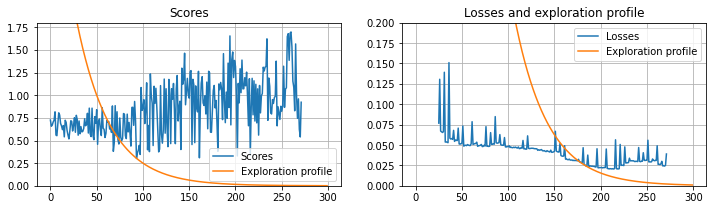

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
#plot scores and losses
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(scores, label='Scores')
plt.title('Scores')
plt.plot(exploration_profile, label='Exploration profile')
plt.ylim(0, 1.8)
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.plot(losses, label='Losses')
plt.title('Losses and exploration profile')
plt.plot(exploration_profile, label='Exploration profile')
plt.ylim(0,0.2)
plt.legend()
plt.grid()
plt.show()

fig.savefig('good_models/hill_scores_losses_exploration.eps', format='eps', dpi=1000)

Adding an exploration profile makes the loss go down, however the score goes down with the loss too

# Final test

In [17]:
# Initialize the Gym environment
env = gym.make(chosen_env) 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
if colab:
  env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
scores = []
for num_episode in range(50): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = -0.5
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=0) 
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      if not colab and show_render:
        env.render()
      # Update the final score (+1 for each step)
      score = max(score, next_state[0]+1.2)
      # Set the current state for the next iteration
      state = next_state
    # Print the final score
    #print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    scores.append(score)  
env.close()

#print the average score
print(f"AVERAGE SCORE: {np.mean(scores):.4f}, environment is always solved for 1.7")

AVERAGE SCORE: 1.7148, environment is always solved for 1.7


In [23]:
#let an agent play for a few episodes   
#doesn't work in colab, but works in local
if not colab:
  env = gym.make(chosen_env)
  #env.seed(42)

  show_render = True

  scores = []
  # Reset the environment and get the initial state
  state = env.reset()
  # Reset the score. The final score will be the total amount of steps before the pole falls
  # Go on
  for i in range(1000):
      # Choose the best action (temperature 0)
      action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=0) if use_epsilon_greedy else choose_action_softmax(policy_net, state, temperature=0) 
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      if not colab and show_render:
          env.render()
      # Set the current state for the next iteration
      state = next_state
  env.close()


In [19]:
if not load_model:
    #save the model
    torch.save(policy_net.state_dict(), f'good_models/hill_policy__net.pt')
    torch.save(target_net.state_dict(), f'good_models/hill_target_net.pt')
    #save losses
    np.save(f'good_models/hill_losses.npy', losses)
    #save scores
    np.save(f'good_models/hill_scores.npy', scores)

In [20]:
# Display the videos, not required outside Colab
if colab: 
    show_videos()